# AUC improved since at least 1 hormone of top 3 hormones and add u'N_pos', u'N_neg', RXCUI

In [63]:
import numpy as np
import pandas as pd
# import sklearn
# from sklearn.metrics import log_loss  
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier                                             
from sklearn.model_selection import KFold     
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('df_preg_hormone_last_numeric3.csv')

print(df.shape)

(3628, 33)


In [64]:
# print(df_new.shape)
df.columns

Index([u'y_preg', u'LANGUAGE_CD', u'RACE_CD', u'ZIP_CD', u'N_pos', u'N_neg',
       u'HDID:149', u'HDID:301', u'HDID:2578', u'HDID:292', u'RXCUI:688242',
       u'HDID:50588', u'ICD9:628.9', u'HDID:7177',
       u'SVC:BMC:OB/GYN-FAMILY PLANNING', u'ICD9:628.8', u'ICD9:628.0',
       u'RXCUI:762001', u'ICD9:628.2', u'RXCUI:206101',
       u'INS:ZZINFERTILITY SVC', u'RXCUI:150840', u'ICD9:628.3',
       u'RXCUI:890918', u'ICD9:V26.21', u'BIRTH_DATE', u'AGE_IN_YEARS_NUM',
       u'CLIN:CurrentCigaretteUse-NO', u'CLIN:EverCigaretteUser-YES',
       u'CLIN:CurrentCigaretteUse-YES', u'CLIN:PassiveCigaretteExposure-NO',
       u'CLIN:PassiveCigaretteExposure-YES', u'AGE_Y'],
      dtype='object')

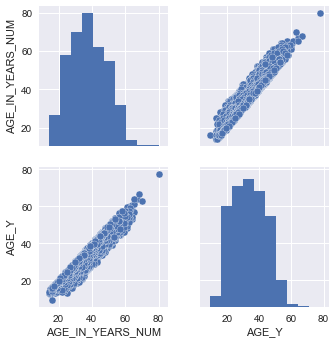

In [65]:
sns.pairplot(df[['AGE_IN_YEARS_NUM', 'AGE_Y']])
plt.show()

In [68]:
# df[['AGE_IN_YEARS_NUM', 'AGE_Y']]
sum(df[['AGE_IN_YEARS_NUM']].values<df[['AGE_Y']].values)

array([60])

# Convert A Categorical Variable Into Dummy Variables

In [34]:
# Create a set of dummy variables from the Categorical variable
# {0: 'DEM|LANGUAGE:ccv', 1: 'DEM|LANGUAGE:creo', 2: 'DEM|LANGUAGE:engl', 3: 'DEM|LANGUAGE:span', 4: 'others'}
col_name=[u'LANGUAGE_CD', u'RACE_CD', u'HDID:2578',u'HDID:50588',u'HDID:7177',u'ICD9:628.9', u'ICD9:628.0', u'ICD9:628.8',u'SVC:BMC:OB/GYN-FAMILY PLANNING', u'RXCUI:762001', u'ICD9:628.2', u'RXCUI:206101',u'INS:ZZINFERTILITY SVC', u'RXCUI:150840', u'ICD9:628.3',u'RXCUI:890918', u'ICD9:V26.21']
df_new =pd.get_dummies(df, prefix=col_name, columns=col_name)
# df_sex = pd.get_dummies(df['LANGUAGE_CD'], columns={'DEM|LANGUAGE:ccv',  'DEM|LANGUAGE:creo',  'DEM|LANGUAGE:engl', 'DEM|LANGUAGE:span',  'DEM|LANGUAGE:others'})
# df_new = pd.concat([df_new, df_sex], axis=1)# axis=0, , ignore_index=True

In [35]:
df_new.columns[df_new.std()<0.01]

Index([], dtype='object')

# missing values

In [36]:
# df_new.loc[df_new.loc[:, col ].isnull(),:]
for col in ['HDID:149','HDID:301','HDID:292']:
    y=df_new.loc[~df_new.loc[:, col ].isnull(),col]
    X=df_new.loc[~df_new.loc[:, col ].isnull(),:].drop([col,'y_preg','ZIP_CD','BIRTH_DATE'], 1).dropna(axis=1, how='any')
    Xmiss=df_new.loc[df_new.loc[:, col ].isnull(),:].drop([col,'y_preg','ZIP_CD','BIRTH_DATE'], 1).dropna(axis=1, how='any')

    # from sklearn.ensemble import RandomForestRegressor
    regressor = RandomForestRegressor(n_estimators=150,max_features=0.33)#, min_samples_split=1
    regressor.fit(X, y)
    df_new.loc[df_new.loc[:, col ].isnull(),col]=regressor.predict(Xmiss)

In [37]:
# dropcolumns = ['LANGUAGE_CDcode_0', 'RACE_CDcode_4','ICD9:628.0code_0','ICD9:628.8code_0','ICD9:628.9code_0','SVC:BMC:OB/GYN-FAMILY PLANNINGcode_-1']
dropcolumns = [u'ZIP_CD',u'BIRTH_DATE','AGE_IN_YEARS_NUM', u'RXCUI:890918_False',
       u'RXCUI:150840_True', u'ICD9:628.2_SECONDARY',
       u'RXCUI:150840_False', u'ICD9:628.2_PROBLEM',
       u'ICD9:V26.21_PRIMARY', u'ICD9:628.8_ADMITTING',
       u'ICD9:V26.21_SECONDARY']#
df_new.drop(dropcolumns, inplace=True, axis=1)
df_new.columns

Index([                                                                u'y_preg',
                                                                        u'N_pos',
                                                                        u'N_neg',
                                                                     u'HDID:149',
                                                                     u'HDID:301',
                                                                     u'HDID:292',
                                                                 u'RXCUI:688242',
                                                  u'CLIN:CurrentCigaretteUse-NO',
                                                   u'CLIN:EverCigaretteUser-YES',
                                                 u'CLIN:CurrentCigaretteUse-YES',
                                             u'CLIN:PassiveCigaretteExposure-NO',
                                            u'CLIN:PassiveCigaretteExposure-YES',
                

In [39]:
df_new.columns[df_new.isnull().any()].tolist()

[]

In [40]:
df=df_new#.loc[:, df_new.columns != col_name]

# # df_new.columns.isin(col_name)
# plt.matshow(df.corr())
# plt.show()

In [41]:
df.describe()

,y_preg,N_pos,N_neg,HDID:149,HDID:301,HDID:292,CLIN:CurrentCigaretteUse-NO,CLIN:EverCigaretteUser-YES,CLIN:CurrentCigaretteUse-YES,CLIN:PassiveCigaretteExposure-NO,...,RXCUI:762001_False,RXCUI:762001_True,ICD9:628.2_PRIMARY,RXCUI:206101_False,RXCUI:206101_True,INS:ZZINFERTILITY SVC_PRIMARY,ICD9:628.3_PRIMARY,ICD9:628.3_SECONDARY,RXCUI:890918_True,ICD9:V26.21_PROBLEM
count,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,...,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000
mean,-0.765711,0.285832,2.720232,9.155368,10.772767,8.066061,0.856395,0.339305,0.275910,0.222437,...,0.991455,0.008545,0.010474,0.996141,0.003859,0.012955,0.001929,0.003032,0.003859,0.004410
std,0.643273,0.990803,4.092433,14.570876,10.858108,7.598875,0.350737,0.473539,0.447033,0.415940,...,0.092054,0.092054,0.101820,0.062008,0.062008,0.113095,0.043889,0.054987,0.062008,0.066271
min,-1.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,0.000000,0.000000,3.700000,4.500000,3.304667,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.000000,0.000000,1.000000,5.200000,8.100000,7.078333,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-1.000000,0.000000,3.000000,7.100000,12.703500,10.543833,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,29.000000,38.000000,165.000000,169.900000,143.500000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
df.groupby('y_preg').median()

,N_pos,N_neg,HDID:149,HDID:301,HDID:292,RXCUI:688242,CLIN:CurrentCigaretteUse-NO,CLIN:EverCigaretteUser-YES,CLIN:CurrentCigaretteUse-YES,CLIN:PassiveCigaretteExposure-NO,...,RXCUI:762001_False,RXCUI:762001_True,ICD9:628.2_PRIMARY,RXCUI:206101_False,RXCUI:206101_True,INS:ZZINFERTILITY SVC_PRIMARY,ICD9:628.3_PRIMARY,ICD9:628.3_SECONDARY,RXCUI:890918_True,ICD9:V26.21_PROBLEM
y_preg,,,,,,,,,,,,,,,,,,,,,
-1,0.0,1.0,5.2,8.125333,6.856000,False,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0.0,1.0,4.7,7.800000,9.347333,False,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


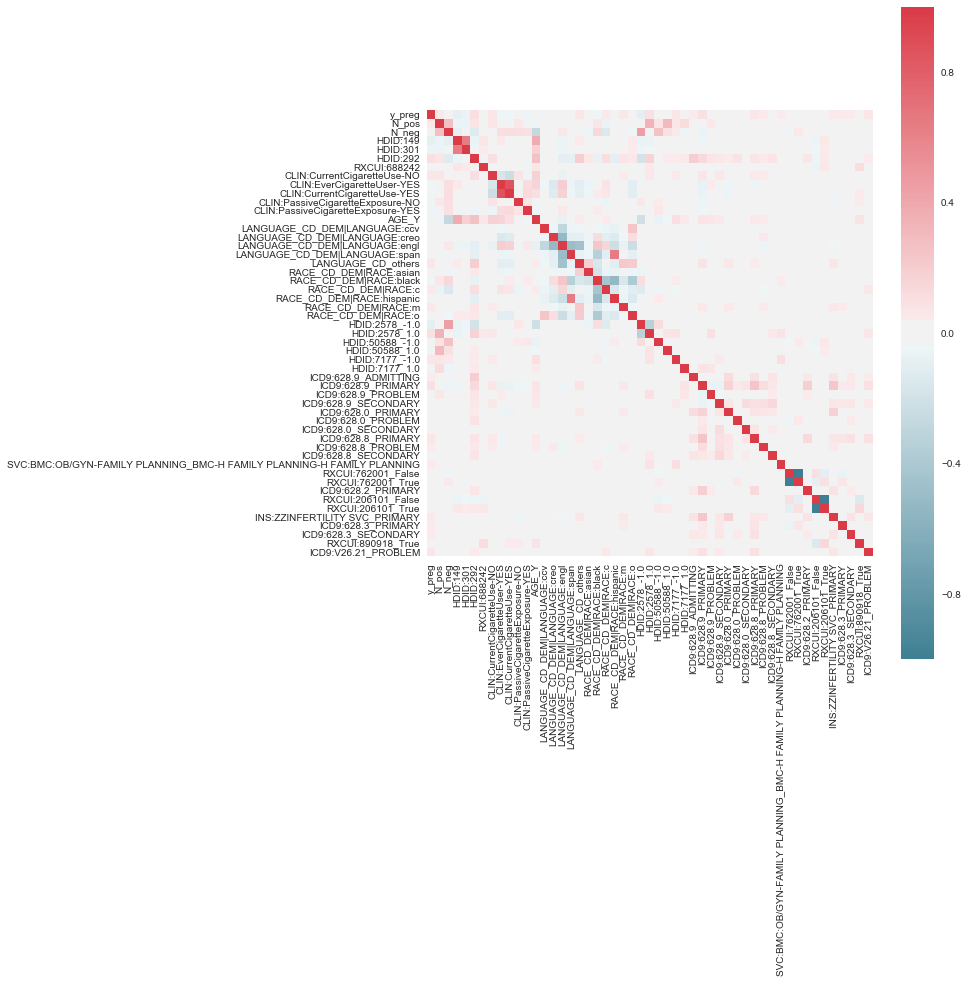

In [44]:
f, ax = plt.subplots(figsize=(10, 12))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [45]:
corr['y_preg']

y_preg                                                                    1.000000
N_pos                                                                     0.048900
N_neg                                                                    -0.030183
HDID:149                                                                 -0.085739
HDID:301                                                                 -0.056838
HDID:292                                                                  0.104432
RXCUI:688242                                                              0.007607
CLIN:CurrentCigaretteUse-NO                                               0.063623
CLIN:EverCigaretteUser-YES                                               -0.040196
CLIN:CurrentCigaretteUse-YES                                             -0.040770
CLIN:PassiveCigaretteExposure-NO                                         -0.025834
CLIN:PassiveCigaretteExposure-YES                                        -0.049371
AGE_

In [71]:
corr['y_preg'].to_frame().sort_values(['y_preg'], ascending=[ False])

,y_preg
y_preg,1.000000
HDID:292,0.104432
ICD9:628.9_PRIMARY,0.090096
HDID:2578_1.0,0.089270
LANGUAGE_CD_others,0.070194
ICD9:628.8_PRIMARY,0.068238
ICD9:V26.21_PROBLEM,0.066300
HDID:7177_-1.0,0.064132
CLIN:CurrentCigaretteUse-NO,0.063623
RACE_CD_DEM|RACE:m,0.057779


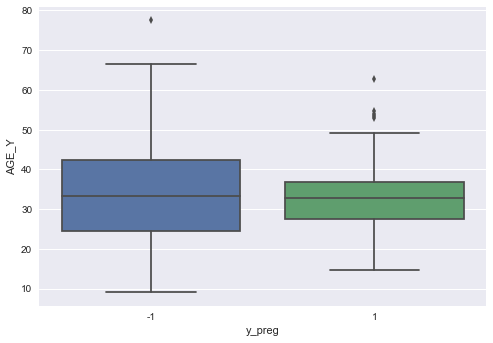

In [46]:
sns.boxplot(x='y_preg',y='AGE_Y',data=df)#,hue='y_preg'
# sns.swarmplot(x='y_preg',y='AGE_Y',data=df)
plt.show()

In [47]:
y=df.y_preg
X=df.loc[:, df.columns != 'y_preg']

# X.head()

In [48]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [49]:
X_train.shape

(2902, 50)

In [50]:
# if not “balanced”, auc=lower
rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features="sqrt", random_state=0,class_weight='balanced')
# rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=0.2, random_state=0)
rf.fit(X_train, y_train)
y_test_pred = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)#, pos_label=1
auc(fpr, tpr)

0.70185875695628563

In [51]:
# # The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.
# rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features="sqrt", random_state=0,class_weight='balanced_subsample')
# # rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=0.2, random_state=0)
# rf.fit(X_train, y_train)
# y_test_pred = rf.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)#, pos_label=1
# auc(fpr, tpr)

In [52]:
#,max_depth=3    0.7431
# ,max_depth=4   0.74146
# ,max_depth=5   0.7390
rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features="sqrt",max_depth=3, random_state=0,class_weight='balanced')
# rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=0.2,max_depth=3, random_state=0)
rf.fit(X_train, y_train)
y_test_pred = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)#, pos_label=1
auc(fpr, tpr)

0.741760197867676

In [53]:
rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=0.6,max_depth=3, random_state=0,class_weight='balanced')
rf.fit(X_train, y_train)
y_test_pred = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)#, pos_label=1
auc(fpr, tpr)

0.74013003803706268

In [54]:
clf =RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True, random_state=0,class_weight='balanced')# RandomForest() 
param_grid = {
                 'max_features': [0.2, 0.3, 0.4, 0.5,0.6,"sqrt"],
                 'max_depth': [3,4,5]
             }
from sklearn.grid_search import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, cv=3,scoring="roc_auc")
grid_clf.fit(X_train, y_train)
print(grid_clf. best_params_)
print(grid_clf. grid_scores_)

{'max_features': 0.2, 'max_depth': 3}
[mean: 0.72645, std: 0.01327, params: {'max_features': 0.2, 'max_depth': 3}, mean: 0.72431, std: 0.01289, params: {'max_features': 0.3, 'max_depth': 3}, mean: 0.72337, std: 0.01300, params: {'max_features': 0.4, 'max_depth': 3}, mean: 0.72309, std: 0.01272, params: {'max_features': 0.5, 'max_depth': 3}, mean: 0.72099, std: 0.01184, params: {'max_features': 0.6, 'max_depth': 3}, mean: 0.72591, std: 0.01343, params: {'max_features': 'sqrt', 'max_depth': 3}, mean: 0.72594, std: 0.01344, params: {'max_features': 0.2, 'max_depth': 4}, mean: 0.72243, std: 0.01184, params: {'max_features': 0.3, 'max_depth': 4}, mean: 0.72293, std: 0.01163, params: {'max_features': 0.4, 'max_depth': 4}, mean: 0.72042, std: 0.01161, params: {'max_features': 0.5, 'max_depth': 4}, mean: 0.71962, std: 0.01185, params: {'max_features': 0.6, 'max_depth': 4}, mean: 0.72476, std: 0.01333, params: {'max_features': 'sqrt', 'max_depth': 4}, mean: 0.72276, std: 0.01377, params: {'max_

In [55]:
# rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=0.2,max_depth=3, random_state=0,class_weight='balanced')
# # rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=0.2,max_depth=3, random_state=0)
# rf.fit(X_train, y_train)
# y_test_pred = rf.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)#, pos_label=1
# auc(fpr, tpr)

In [56]:
grid_clf. best_params_['max_depth']

3

In [57]:
rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=grid_clf. best_params_['max_features'],max_depth=grid_clf. best_params_['max_depth'], random_state=0,class_weight='balanced')
# rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,oob_score=True,max_features=0.2,max_depth=3, random_state=0)
rf.fit(X_train, y_train)
y_test_pred = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)#, pos_label=1
auc(fpr, tpr)

0.74213494725402396

In [58]:
oob_error = 1 - rf.oob_score_
print(oob_error)

0.34011026878


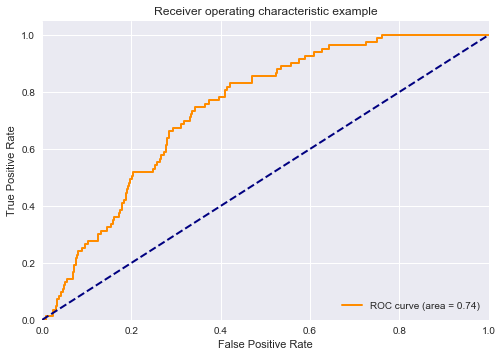

In [59]:
roc_auc=auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# View Feature Importance


In [60]:
# list(zip(X.columns, rf.feature_importances_))#.to_frame()

importances=pd.DataFrame(zip(X.columns, rf.feature_importances_))

importances.columns=['name','importances']

importances.sort_values(by=['importances'], ascending=[False])#

,name,importances
11,AGE_Y,0.326723
4,HDID:292,0.180116
2,HDID:149,0.126162
23,HDID:2578_-1.0,0.053343
3,HDID:301,0.052179
0,N_pos,0.046369
24,HDID:2578_1.0,0.029231
30,ICD9:628.9_PRIMARY,0.023948
6,CLIN:CurrentCigaretteUse-NO,0.017893
1,N_neg,0.016317


In [61]:
importances.sort_values(by=['importances'], ascending=[False])['name'].values

array(['AGE_Y', 'HDID:292', 'HDID:149', u'HDID:2578_-1.0', 'HDID:301',
       'N_pos', u'HDID:2578_1.0', u'ICD9:628.9_PRIMARY',
       'CLIN:CurrentCigaretteUse-NO', 'N_neg', u'LANGUAGE_CD_others',
       'CLIN:PassiveCigaretteExposure-YES', u'ICD9:628.8_PRIMARY',
       u'LANGUAGE_CD_DEM|LANGUAGE:span', u'RACE_CD_DEM|RACE:c',
       u'RACE_CD_DEM|RACE:black', u'HDID:7177_-1.0',
       'CLIN:PassiveCigaretteExposure-NO', u'ICD9:628.8_PROBLEM',
       u'ICD9:628.3_PRIMARY', u'RACE_CD_DEM|RACE:hispanic',
       u'SVC:BMC:OB/GYN-FAMILY PLANNING_BMC-H FAMILY PLANNING-H FAMILY PLANNING',
       'CLIN:EverCigaretteUser-YES', u'ICD9:628.9_SECONDARY',
       u'INS:ZZINFERTILITY SVC_PRIMARY', 'CLIN:CurrentCigaretteUse-YES',
       u'ICD9:628.9_PROBLEM', u'ICD9:628.2_PRIMARY', u'RXCUI:762001_False',
       u'ICD9:628.3_SECONDARY', u'RACE_CD_DEM|RACE:m',
       u'ICD9:628.0_PROBLEM', u'LANGUAGE_CD_DEM|LANGUAGE:engl',
       u'RXCUI:762001_True', u'LANGUAGE_CD_DEM|LANGUAGE:creo',
       u'HDID:717